Used DCN algoruthm from github 
https://github.com/AaronX121/Deep-Clustering-Network


In [2]:
import numpy as np
from sklearn.cluster import KMeans
from joblib import Parallel, delayed


def _parallel_compute_distance(X, cluster):
    n_samples = X.shape[0]
    dis_mat = np.zeros((n_samples, 1))
    for i in range(n_samples):
        dis_mat[i] += np.sqrt(np.sum((X[i] - cluster) ** 2, axis=0))
    return dis_mat


class batch_KMeans(object):
    
    def __init__(self, args):
        self.args = args
        self.n_features = args.latent_dim
        self.n_clusters = args.n_clusters
        self.clusters = np.zeros((self.n_clusters, self.n_features))
        self.count = 100 * np.ones((self.n_clusters))  # serve as learning rate
        self.n_jobs = args.n_jobs
    
    def _compute_dist(self, X):
        dis_mat = Parallel(n_jobs=self.n_jobs)(
            delayed(_parallel_compute_distance)(X, self.clusters[i])
            for i in range(self.n_clusters))
        dis_mat = np.hstack(dis_mat)
        
        return dis_mat
    
    def init_cluster(self, X, indices=None):
        """ Generate initial clusters using sklearn.Kmeans """
        model = KMeans(n_clusters=self.n_clusters,
                       n_init=20)
        model.fit(X)
        self.clusters = model.cluster_centers_  # copy clusters
    
    def update_cluster(self, X, cluster_idx):
        """ Update clusters in Kmeans on a batch of data """
        n_samples = X.shape[0]
        for i in range(n_samples):
            self.count[cluster_idx] += 1
            eta = 1.0 / self.count[cluster_idx]
            updated_cluster = ((1 - eta) * self.clusters[cluster_idx] + 
                               eta * X[i])
            self.clusters[cluster_idx] = updated_cluster
    
    def update_assign(self, X):
        """ Assign samples in `X` to clusters """
        dis_mat = self._compute_dist(X)
        
        return np.argmin(dis_mat, axis=1)

## Autoencoder

In [3]:
import torch.nn as nn
from collections import OrderedDict


class AutoEncoder(nn.Module):
    
    def __init__(self, args):
        super(AutoEncoder, self).__init__()
        self.args = args
        self.input_dim = args.input_dim
        self.output_dim = self.input_dim
        self.hidden_dims = args.hidden_dims
        self.dims_list = (args.hidden_dims + 
                          args.hidden_dims[:-1][::-1])  # mirrored structure
        self.n_layers = len(self.dims_list)
        self.n_classes = args.n_classes
        
        # Validation check
        assert self.n_layers % 2 > 0
        assert self.dims_list[self.n_layers // 2] == self.n_classes
        
        # Encoder Network
        layers = OrderedDict()
        for idx, hidden_dim in enumerate(self.hidden_dims):
            if idx == 0:
                layers.update(
                    {'linear0': nn.Linear(self.input_dim, hidden_dim),
                     'activation0': nn.ReLU()
                    })
            else:
                layers.update(
                    {'linear{}'.format(idx): nn.Linear(
                        self.hidden_dims[idx-1], hidden_dim),
                     'activation{}'.format(idx): nn.ReLU(),
                     'bn{}'.format(idx): nn.BatchNorm1d(self.hidden_dims[idx])
                    })
        self.encoder = nn.Sequential(layers)
        
        # Decoder Network
        layers = OrderedDict()
        tmp_hidden_dims = self.hidden_dims[::-1]
        for idx, hidden_dim in enumerate(tmp_hidden_dims):
            if idx == len(tmp_hidden_dims) - 1:
                layers.update(
                    {'linear{}'.format(idx): nn.Linear(
                        hidden_dim, self.output_dim),
                    })
            else:
                layers.update(
                    {'linear{}'.format(idx): nn.Linear(
                        hidden_dim, tmp_hidden_dims[idx+1]),
                     'activation{}'.format(idx): nn.ReLU(),
                     'bn{}'.format(idx): nn.BatchNorm1d(tmp_hidden_dims[idx+1])
                    })
        self.decoder = nn.Sequential(layers)
    
    def __repr__(self):
        repr_str = '[Structure]: {}-'.format(self.input_dim)
        for idx, dim in enumerate(self.dims_list):
                repr_str += '{}-'.format(dim)
        repr_str += str(self.output_dim) + '\n'
        repr_str += '[n_layers]: {}'.format(self.n_layers) + '\n'
        repr_str += '[n_classes]: {}'.format(self.n_classes) + '\n'
        repr_str += '[input_dims]: {}'.format(self.input_dim)
        return repr_str
    
    def __str__(self):
        return self.__repr__()
    
    def forward(self, X, latent=False):
        output = self.encoder(X)
        if latent:
            return output
        return self.decoder(output)

In [53]:
import torch
import numbers
import numpy as np
import torch.nn as nn
#from kmeans import batch_KMeans
#from autoencoder import AutoEncoder


class DCN(nn.Module):
    
    def __init__(self, args):
        super(DCN, self).__init__()
        self.args = args
        self.beta = args.beta  # coefficient of the clustering term 
        self.lamda = args.lamda  # coefficient of the reconstruction term
        self.device = torch.device('cuda' if args.cuda else 'cpu')
        
        # Validation check
        if not self.beta > 0:
            msg = 'beta should be greater than 0 but got value = {}.'
            raise ValueError(msg.format(self.beta))
        
        if not self.lamda > 0:
            msg = 'lambda should be greater than 0 but got value = {}.'
            raise ValueError(msg.format(self.lamda))
        
        if not self.args.n_clusters == self.args.n_classes:
            msg = '`args.n_clusters = {} should equal `args.n_classes = {}`.'
            raise ValueError(msg.format(self.args.n_clusters,
                                        self.args.n_classes))
        
        if len(self.args.hidden_dims) == 0:
            raise ValueError('No hidden layer specified.')
        
        self.kmeans = batch_KMeans(args)
        self.autoencoder = AutoEncoder(args).to(self.device)
        
        self.criterion  = nn.MSELoss(reduction='sum')
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=args.lr,
                                          weight_decay=args.wd)
    
    """ Compute the  Equation(5) in the original paper on a data batch """
    def _loss(self, X, cluster_id):
        batch_size = X.size()[0]
        rec_X = self.autoencoder(X)
        latent_X = self.autoencoder(X, latent=True)
        
        # Reconstruction error
        rec_loss = self.lamda * self.criterion(X, rec_X)
        
        # Regularization term on clustering
        dist_loss = torch.tensor(0.).to(self.device)
        clusters = torch.FloatTensor(self.kmeans.clusters).to(self.device)
        for i in range(batch_size):
            diff_vec = latent_X[i] - clusters[cluster_id[i]]
            sample_dist_loss = torch.matmul(diff_vec.view(1, -1),
                                            diff_vec.view(-1, 1))
            dist_loss += 0.5 * self.beta * torch.squeeze(sample_dist_loss)
        
        return (rec_loss + dist_loss, 
                rec_loss.detach().cpu().numpy(),
                dist_loss.detach().cpu().numpy())
    
    def pretrain(self, train_loader, epoch=50, verbose=True):
        
        if not self.args.pretrain:
            return
        
        if not isinstance(epoch, numbers.Integral):
            msg = '`epoch` should be an integer but got value = {}'
            raise ValueError(msg.format(epoch))
        
        if verbose:
            print('========== Start pretraining ==========')
        
        rec_loss_list  =[]
        
        self.train()
        for e in range(epoch):
            for batch_idx, (data, _) in enumerate(train_loader):
                batch_size = data.size()[0]
                data = data.to(self.device).view(batch_size, -1)
                rec_X = self.autoencoder(data)
                loss = self.criterion(data, rec_X)
                
                if verbose and batch_idx % self.args.log_interval == 0:
                    msg = 'Epoch: {:02d} | Batch: {:03d} | Rec-Loss: {:.3f}'
                    print(msg.format(e, batch_idx, 
                                     loss.detach().cpu().numpy()))
                    rec_loss_list.append(loss.detach().cpu().numpy())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        self.eval()
        
        if verbose:
            print('========== End pretraining ==========\n')
        
        # Initialize clusters in self.kmeans after pre-training
        batch_X = []
        for batch_idx, (data, _) in enumerate(train_loader):
            batch_size = data.size()[0]
            data = data.to(self.device).view(batch_size, -1)
            latent_X = self.autoencoder(data, latent=True)
            batch_X.append(latent_X.detach().cpu().numpy())
        batch_X = np.vstack(batch_X)
        self.kmeans.init_cluster(batch_X)
        
        return rec_loss_list
    
    def fit(self, epoch, train_loader, verbose=True):
        
        for batch_idx, (data, _) in enumerate(train_loader):
            batch_size = data.size()[0]
            data = data.view(batch_size, -1).to(self.device)
            
            # Get the latent features
            with torch.no_grad():
                latent_X = self.autoencoder(data, latent=True)
                latent_X = latent_X.cpu().numpy()
            
            # [Step-1] Update the assignment results
            cluster_id = self.kmeans.update_assign(latent_X)
            
            # [Step-2] Update clusters in bath Kmeans
            elem_count = np.bincount(cluster_id, 
                                     minlength=self.args.n_clusters)
            for k in range(self.args.n_clusters):
                # avoid empty slicing
                if elem_count[k] == 0:
                    continue
                self.kmeans.update_cluster(latent_X[cluster_id == k], k)
            
            # [Step-3] Update the network parameters         
            loss, rec_loss, dist_loss = self._loss(data, cluster_id)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if verbose and batch_idx % self.args.log_interval == 0:
                msg = 'Epoch: {:02d} | Batch: {:03d} | Loss: {:.3f} | Rec-' \
                      'Loss: {:.3f} | Dist-Loss: {:.3f}'
                print(msg.format(epoch, batch_idx, 
                                 loss.detach().cpu().numpy(),
                                 rec_loss, dist_loss))

## MNIST train

In [5]:
import torch
import argparse
import numpy as np
#from DCN import DCN
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import accuracy_score
def evaluate(model, test_loader):
    y_test = []
    y_pred = []
    for data, target in test_loader:
        batch_size = data.size()[0]
        data = data.view(batch_size, -1).to(model.device)
        latent_X = model.autoencoder(data, latent=True)
        latent_X = latent_X.detach().cpu().numpy()

        y_test.append(target.view(-1, 1).numpy())
        y_pred.append(model.kmeans.update_assign(latent_X).reshape(-1, 1))
    
    y_test = np.vstack(y_test).reshape(-1)
    y_pred = np.vstack(y_pred).reshape(-1)

    #accuracy
    clusters=np.unique(y_pred)
    y_predict=np.empty(len(y_test))
    
    for cluster in clusters:
        #1 find the average value in the class and predict value sing average value
        mask_cluster=y_pred==cluster
        mean_pred=np.bincount(y_test[mask_cluster]).argmax()
        y_predict[mask_cluster]=mean_pred
    my_accur=accuracy_score(y_test, y_predict)
    sse=np.sum((y_test-y_predict)**2)




    #print(y_pred,type(y_pred),np.unique(y_pred))
    return (normalized_mutual_info_score(y_test, y_pred),
            adjusted_rand_score(y_test, y_pred), my_accur,sse)

def solver(args, model, train_loader, test_loader):
    
    rec_loss_list = model.pretrain(train_loader)
    nmi_list = []
    ari_list = []
    accur_list=[]
    sse_list=[]
    for e in range(args.epoch):
        model.train()
        model.fit(e, train_loader)
        
        model.eval()
        NMI, ARI, accur, sse = evaluate(model, test_loader)  # evaluation on the test_loader
        nmi_list.append(NMI)
        ari_list.append(ARI)
        accur_list.append(accur)
        sse_list.append(sse)
        print('\nEpoch: {:02d} | NMI: {:.3f} | ARI: {:.3f}| Accuracy: {:.3f}| SSE: {:.3f}\n'.format(
            e, NMI, ARI, accur, sse))

    return rec_loss_list, nmi_list, ari_list, accur_list, sse_list


if __name__ == '__main__':
    
    parser = argparse.ArgumentParser(description='Deep Clustering Network')

    # Dataset parameters
    parser.add_argument('--dir', default='../Dataset/mnist', 
                        help='dataset directory')
    parser.add_argument('--input-dim', type=int, default=28*28, 
                        help='input dimension')
    parser.add_argument('--n-classes', type=int, default=10, 
                        help='output dimension')

    # Training parameters
    parser.add_argument('--lr', type=float, default=1e-4, 
                        help='learning rate (default: 1e-4)')
    parser.add_argument('--wd', type=float, default=5e-4, 
                        help='weight decay (default: 5e-4)')
    parser.add_argument('--batch-size', type=int, default=256, 
                        help='input batch size for training')
    parser.add_argument('--epoch', type=int, default=20, 
                        help='number of epochs to train')
    parser.add_argument('--pretrain', type=bool, default=True, 
                        help='whether use pre-training')
    
    # Model parameters
    parser.add_argument('--lamda', type=float, default=1, 
                        help='coefficient of the reconstruction loss')
    parser.add_argument('--beta', type=float, default=1, 
                        help='coefficient of the regularization term on ' \
                            'clustering')
    parser.add_argument('--hidden-dims', default=[500, 500, 2000, 10], 
                        help='learning rate (default: 1e-4)')
    parser.add_argument('--latent_dim', type=int, default=10, 
                        help='latent space dimension')
    parser.add_argument('--n-clusters', type=int, default=10, 
                        help='number of clusters in the latent space')

    # Utility parameters
    parser.add_argument('--n-jobs', type=int, default=1, 
                        help='number of jobs to run in parallel')
    parser.add_argument('--cuda', type=bool, default=True, 
                        help='whether to use GPU')
    parser.add_argument('--log-interval', type=int, default=100, 
                        help='how many batches to wait before logging the ' \
                           'training status')

    args, unknown = parser.parse_known_args()

    
    # Load data
    transformer = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),
                                                           (0.3081,))])
    train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(args.dir,train=True, download=True, 
                       transform=transformer), 
        batch_size=args.batch_size, shuffle=False)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(args.dir,download=True, train=True, transform=transformer), 
        batch_size=256, shuffle=True)

    # Main body
    model = DCN(args)    
    rec_loss_list, nmi_list, ari_list,accur_list, sse_list = solver(
        args, model, train_loader, test_loader)

========== Start pretraining ==========
Epoch: 00 | Batch: 000 | Rec-Loss: 264060.844
Epoch: 00 | Batch: 100 | Rec-Loss: 137429.422
Epoch: 00 | Batch: 200 | Rec-Loss: 134223.094
Epoch: 01 | Batch: 000 | Rec-Loss: 116283.062
Epoch: 01 | Batch: 100 | Rec-Loss: 96728.992
Epoch: 01 | Batch: 200 | Rec-Loss: 86857.359
Epoch: 02 | Batch: 000 | Rec-Loss: 73921.547
Epoch: 02 | Batch: 100 | Rec-Loss: 64069.094
Epoch: 02 | Batch: 200 | Rec-Loss: 62044.938
Epoch: 03 | Batch: 000 | Rec-Loss: 56889.656
Epoch: 03 | Batch: 100 | Rec-Loss: 55188.594
Epoch: 03 | Batch: 200 | Rec-Loss: 54593.426
Epoch: 04 | Batch: 000 | Rec-Loss: 51812.117
Epoch: 04 | Batch: 100 | Rec-Loss: 51984.594
Epoch: 04 | Batch: 200 | Rec-Loss: 51400.742
Epoch: 05 | Batch: 000 | Rec-Loss: 49020.355
Epoch: 05 | Batch: 100 | Rec-Loss: 49655.023
Epoch: 05 | Batch: 200 | Rec-Loss: 49240.949
Epoch: 06 | Batch: 000 | Rec-Loss: 47012.918
Epoch: 06 | Batch: 100 | Rec-Loss: 47769.555
Epoch: 06 | Batch: 200 | Rec-Loss: 47513.305
Epoch: 07 |

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


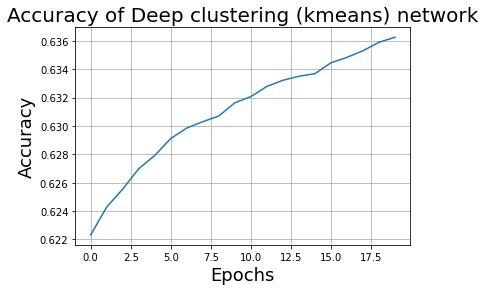

In [13]:
plot(accur_list)
xlabel('Epochs',fontsize=18)
ylabel('Accuracy',fontsize=18)
title('Accuracy of Deep clustering (kmeans) network',fontsize=20)
grid()

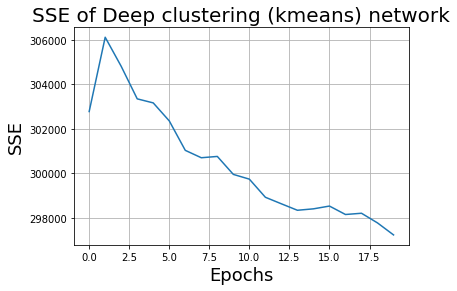

In [14]:
plot(sse_list)
xlabel('Epochs',fontsize=18)
ylabel('SSE',fontsize=18)
title('SSE of Deep clustering (kmeans) network',fontsize=20)
grid()

In [6]:

tsfm = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))])

mnist_ds = datasets.MNIST(root='../../../_data/mnist',train=True,
                                download=True, transform=tsfm)

Extracting ../../../_data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../../_data/mnist/MNIST/raw


Extracting ../../../_data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../../_data/mnist/MNIST/raw


Extracting ../../../_data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../../_data/mnist/MNIST/raw


Extracting ../../../_data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../../_data/mnist/MNIST/raw
Processing...
Done!


In [11]:
mnist_ds[6000]

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4115, -0.1187,  0.4159, -0.0806, -0.4242, -0.4242,
           -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4115,  0.0849,  1.7269,  2.1723,  0.2504, -0.4242, -0.4242,
           -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.3988,
            0.1231,  1.8414,  2.0323,  0.3649, -0.3733, -0.4242, -0.4242,
           -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.0678,
            1.8287,  2.3124,  0.4668, -0.3860, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.3351,  1.1541,
            2.4906,  0.9759, -0.3478

## Glass train

In [6]:

from google.colab import drive
drive.mount('/content/drive')
#plt.savefig('/content/drive/My Drive/Bifur_map.png')

Mounted at /content/drive


In [7]:
#from google.colab import files
import pandas as pd

glass=pd.read_csv('/content/drive/My Drive/glass.csv')

In [8]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
glass['Type']=le.fit_transform(glass['Type'])

In [9]:
# convert numpy arrays to pytorch tensors
import numpy as np

X_train = torch.stack([torch.from_numpy(i) for i in glass[glass.columns[:-1]].to_numpy()])
y_train = torch.stack([torch.from_numpy(np.array(i)) for i in glass['Type']])

# create dataset and dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

In [10]:
for data,target in train_loader:
  pass

In [14]:
from timeit import default_timer as timer

In [20]:
import torch
import argparse
import numpy as np
#from DCN import DCN
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import accuracy_score
def evaluate(model, test_loader):
    y_test = []
    y_pred = []
    for data, target in test_loader:
        batch_size = data.size()[0]
        data = data.view(batch_size, -1).to(model.device)
        latent_X = model.autoencoder(data, latent=True)
        latent_X = latent_X.detach().cpu().numpy()

        y_test.append(target.view(-1, 1).numpy())
        y_pred.append(model.kmeans.update_assign(latent_X).reshape(-1, 1))
    
    y_test = np.vstack(y_test).reshape(-1)
    y_pred = np.vstack(y_pred).reshape(-1)

    #accuracy
    clusters=np.unique(y_pred)
    y_predict=np.empty(len(y_test))
    
    for cluster in clusters:
        #1 find the average value in the class and predict value sing average value
        mask_cluster=y_pred==cluster
        mean_pred=np.bincount(y_test[mask_cluster]).argmax()
        y_predict[mask_cluster]=mean_pred
    my_accur=accuracy_score(y_test, y_predict)
    sse=np.sum((y_test-y_predict)**2)




    #print(y_pred,type(y_pred),np.unique(y_pred))
    return (normalized_mutual_info_score(y_test, y_pred),
            adjusted_rand_score(y_test, y_pred), my_accur,sse)

def solver(args, model, train_loader, test_loader):
    
    rec_loss_list = model.pretrain(train_loader)
    nmi_list = []
    ari_list = []
    accur_list=[]
    sse_list=[]
    for e in range(args.epoch):
        model.train()
        model.fit(e, train_loader)
        
        model.eval()
        NMI, ARI, accur, sse = evaluate(model, test_loader)  # evaluation on the test_loader
        nmi_list.append(NMI)
        ari_list.append(ARI)
        accur_list.append(accur)
        sse_list.append(sse)
        print('\nEpoch: {:02d} | NMI: {:.3f} | ARI: {:.3f}| Accuracy: {:.3f}| SSE: {:.3f}\n'.format(
            e, NMI, ARI, accur, sse))

    return rec_loss_list, nmi_list, ari_list, accur_list, sse_list


if __name__ == '__main__':
    
    parser = argparse.ArgumentParser(description='Deep Clustering Network')

    # Dataset parameters
    parser.add_argument('--dir', default='../Dataset/mnist', 
                        help='dataset directory')
    parser.add_argument('--input-dim', type=int, default=9, 
                        help='input dimension')
    parser.add_argument('--n-classes', type=int, default=9, 
                        help='output dimension')

    # Training parameters
    parser.add_argument('--lr', type=float, default=1e-4, 
                        help='learning rate (default: 1e-4)')
    parser.add_argument('--wd', type=float, default=5e-4, 
                        help='weight decay (default: 5e-4)')
    parser.add_argument('--batch-size', type=int, default=64, 
                        help='input batch size for training')
    parser.add_argument('--epoch', type=int, default=100, 
                        help='number of epochs to train')
    parser.add_argument('--pretrain', type=bool, default=True, 
                        help='whether use pre-training')
    
    # Model parameters
    parser.add_argument('--lamda', type=float, default=1, 
                        help='coefficient of the reconstruction loss')
    parser.add_argument('--beta', type=float, default=1, 
                        help='coefficient of the regularization term on ' \
                            'clustering')
    parser.add_argument('--hidden-dims', default=[500, 500, 2000, 9], 
                        help='learning rate (default: 1e-4)')
    parser.add_argument('--latent_dim', type=int, default=9, 
                        help='latent space dimension')
    parser.add_argument('--n-clusters', type=int, default=9, 
                        help='number of clusters in the latent space')

    # Utility parameters
    parser.add_argument('--n-jobs', type=int, default=1, 
                        help='number of jobs to run in parallel')
    parser.add_argument('--cuda', type=bool, default=True, 
                        help='whether to use GPU')
    parser.add_argument('--log-interval', type=int, default=100, 
                        help='how many batches to wait before logging the training status')

    args, unknown = parser.parse_known_args()

    
    # Load data
    
     # convert numpy arrays to pytorch tensors


    X_train = torch.stack([torch.from_numpy(i) for i in glass[glass.columns[:-1]].to_numpy()])
    y_train = torch.stack([torch.from_numpy(np.array(i)) for i in glass['Type']])
    # create dataset and dataloaders
    
    X_train = X_train.float()
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
    test_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=64)                                                       
    
    
    

    # Main body
    start=timer()
    model = DCN(args)    
    rec_loss_list, nmi_list, ari_list,accur_list, sse_list = solver(
        args, model, train_loader, test_loader)
    end=timer()
    print('Time ',end-start)

========== Start pretraining ==========
========== End pretraining ==========

Epoch: 00 | Batch: 000 | Loss: 356046.531 | Rec-Loss: 355708.250 | Dist-Loss: 338.266

Epoch: 00 | NMI: 0.031 | ARI: -0.010| Accuracy: 0.355| SSE: 544.000

Epoch: 01 | Batch: 000 | Loss: 355593.156 | Rec-Loss: 355343.062 | Dist-Loss: 250.087

Epoch: 01 | NMI: 0.275 | ARI: 0.176| Accuracy: 0.519| SSE: 444.000

Epoch: 02 | Batch: 000 | Loss: 355464.000 | Rec-Loss: 355252.438 | Dist-Loss: 211.552

Epoch: 02 | NMI: 0.276 | ARI: 0.174| Accuracy: 0.453| SSE: 461.000

Epoch: 03 | Batch: 000 | Loss: 355326.688 | Rec-Loss: 355135.125 | Dist-Loss: 191.557

Epoch: 03 | NMI: 0.293 | ARI: 0.201| Accuracy: 0.491| SSE: 376.000

Epoch: 04 | Batch: 000 | Loss: 355228.656 | Rec-Loss: 355051.719 | Dist-Loss: 176.934

Epoch: 04 | NMI: 0.232 | ARI: 0.162| Accuracy: 0.463| SSE: 476.000

Epoch: 05 | Batch: 000 | Loss: 355149.406 | Rec-Loss: 354981.750 | Dist-Loss: 167.653

Epoch: 05 | NMI: 0.260 | ARI: 0.197| Accuracy: 0.491| SSE:

In [21]:
print('Accuracy on 9 classes =',accur_list[-1])

Accuracy on 9 classes = 0.5


In [19]:
print('Accuracy on 6 classes =',accur_list[-1])

Accuracy on 6 classes = 0.5373831775700935


In [12]:
print('Accuracy on 3 clusters=',accur_list[-1])

Accuracy= 0.48598130841121495


Populating the interactive namespace from numpy and matplotlib


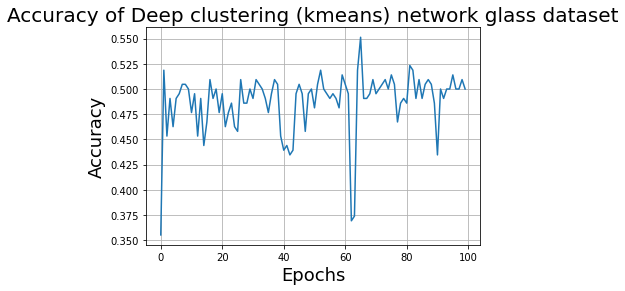

In [22]:
%pylab inline
plot(accur_list)
xlabel('Epochs',fontsize=18)
ylabel('Accuracy',fontsize=18)
title('Accuracy of Deep clustering (kmeans) network glass dataset',fontsize=20)
grid()

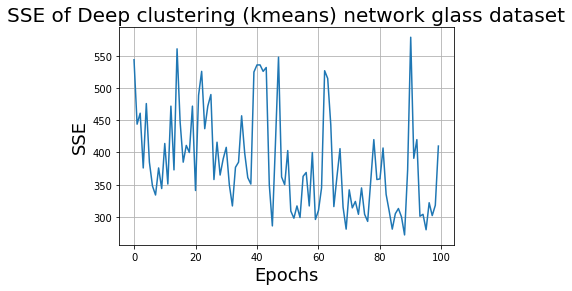

In [23]:
plot(sse_list)
xlabel('Epochs',fontsize=18)
ylabel('SSE',fontsize=18)
title('SSE of Deep clustering (kmeans) network glass dataset',fontsize=20)
grid()

## Segments dataset

In [24]:
## Segements  
segments=pd.read_csv('/content/drive/My Drive/segments.csv')

In [25]:
from sklearn import preprocessing 

le = preprocessing.LabelEncoder()

segments['class']=le.fit_transform(segments['class'])
segments.head()
segments=segments.drop('Unnamed: 0',axis=1)

In [26]:
X_train = torch.stack([torch.from_numpy(i) for i in segments[segments.columns[:-1]].to_numpy()])
y_train = torch.stack([torch.from_numpy(np.array(i)) for i in segments['class']])
    # create dataset and dataloaders
    
X_train = X_train.float()
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=100)                                                       
    

In [27]:
for data, lab in test_loader:

  print(data.size()[1])

19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19


In [34]:
if __name__ == '__main__':
    
    parser = argparse.ArgumentParser(description='Deep Clustering Network')

    # Dataset parameters
    
    parser.add_argument('--input-dim', type=int, default=19, 
                        help='input dimension')
    parser.add_argument('--n-classes', type=int, default=10, 
                        help='output dimension')

    # Training parameters
    parser.add_argument('--lr', type=float, default=1e-4, 
                        help='learning rate (default: 1e-4)')
    parser.add_argument('--wd', type=float, default=5e-4, 
                        help='weight decay (default: 5e-4)')
    parser.add_argument('--batch-size', type=int, default=300, 
                        help='input batch size for training')
    parser.add_argument('--epoch', type=int, default=100, 
                        help='number of epochs to train')
    parser.add_argument('--pretrain', type=bool, default=True, 
                        help='whether use pre-training')
    
    # Model parameters
    parser.add_argument('--lamda', type=float, default=1, 
                        help='coefficient of the reconstruction loss')
    parser.add_argument('--beta', type=float, default=1, 
                        help='coefficient of the regularization term on ' \
                            'clustering')
    parser.add_argument('--hidden-dims', default=[500, 500, 2000, 10], 
                        help='learning rate (default: 1e-4)')
    parser.add_argument('--latent_dim', type=int, default=10, 
                        help='latent space dimension')
    parser.add_argument('--n-clusters', type=int, default=10, 
                        help='number of clusters in the latent space')

    # Utility parameters
    parser.add_argument('--n-jobs', type=int, default=1, 
                        help='number of jobs to run in parallel')
    parser.add_argument('--cuda', type=bool, default=True, 
                        help='whether to use GPU')
    parser.add_argument('--log-interval', type=int, default=100, 
                        help='how many batches to wait before logging the ' \
                           'training status')

    args, unknown = parser.parse_known_args()

    
    # Load data
    
     # convert numpy arrays to pytorch tensors


    X_train = torch.stack([torch.from_numpy(i) for i in segments[segments.columns[:-1]].to_numpy()])
    y_train = torch.stack([torch.from_numpy(np.array(i)) for i in segments['class']])
    # create dataset and dataloaders
    
    X_train = X_train.float()
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=300)
    test_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=300)                                                       
    
    
    start=timer()

    # Main body
    model = DCN(args)    
    rec_loss_list, nmi_list, ari_list,accur_list, sse_list = solver(
        args, model, train_loader, test_loader)
    end=timer()
    print(end-start)

========== Start pretraining ==========
========== End pretraining ==========

Epoch: 00 | Batch: 000 | Loss: 16511061.000 | Rec-Loss: 16509815.000 | Dist-Loss: 1245.874

Epoch: 00 | NMI: 0.147 | ARI: 0.035| Accuracy: 0.262| SSE: 13972.000

Epoch: 01 | Batch: 000 | Loss: 16074152.000 | Rec-Loss: 16073090.000 | Dist-Loss: 1062.227

Epoch: 01 | NMI: 0.273 | ARI: 0.135| Accuracy: 0.377| SSE: 8996.000

Epoch: 02 | Batch: 000 | Loss: 15886026.000 | Rec-Loss: 15885152.000 | Dist-Loss: 873.674

Epoch: 02 | NMI: 0.310 | ARI: 0.188| Accuracy: 0.400| SSE: 12874.000

Epoch: 03 | Batch: 000 | Loss: 15774728.000 | Rec-Loss: 15773962.000 | Dist-Loss: 765.683

Epoch: 03 | NMI: 0.324 | ARI: 0.201| Accuracy: 0.406| SSE: 12981.000

Epoch: 04 | Batch: 000 | Loss: 15693174.000 | Rec-Loss: 15692468.000 | Dist-Loss: 705.764

Epoch: 04 | NMI: 0.330 | ARI: 0.206| Accuracy: 0.409| SSE: 12981.000

Epoch: 05 | Batch: 000 | Loss: 15622945.000 | Rec-Loss: 15622268.000 | Dist-Loss: 677.157

Epoch: 05 | NMI: 0.338 |

In [29]:
print('Accuracy on 7',0.377)

Accuracy on 7 0.377


In [33]:
print('Accuracy on 3 clusters=',accur_list[-1])

Accuracy on 3 clusters= 0.1510822510822511


In [35]:
print('Accuracy on 10 clusters=',accur_list[-1])

Accuracy on 10 clusters= 0.42077922077922075


Populating the interactive namespace from numpy and matplotlib


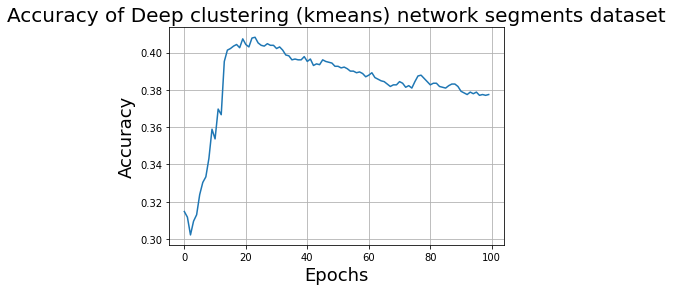

In [146]:
%pylab inline
plot(accur_list)
xlabel('Epochs',fontsize=18)
ylabel('Accuracy',fontsize=18)
title('Accuracy of Deep clustering (kmeans) network segments dataset',fontsize=20)
grid()

## Isolet5 dataset

In [36]:
isolet5=pd.read_csv('/content/drive/My Drive/isolet5.data',header=None,decimal='.')
isolet5.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617
0,-0.2080,0.3480,0.3280,0.5040,0.9320,1.0000,0.8360,0.6680,0.2720,0.2400,0.0960,0.1280,0.1160,0.3120,0.2640,0.5520,0.7200,0.8280,0.7720,0.7840,0.7360,0.6200,0.6240,0.5880,0.7280,0.8160,0.8520,0.7240,0.6600,0.7320,0.6920,0.6800,-0.2024,0.2672,0.4574,0.5790,0.8826,0.8462,1.0000,0.8098,...,-1.0,1.0,-1.0,-1.0,-0.8,-0.6334,-1.0,-0.1406,0.3594,0.3750,0.6562,0.3750,0.1876,0.4062,0.2032,0.5782,1.0000,0.9844,0.8750,0.8594,0.7032,0.4844,0.5782,0.8124,0.6406,0.4688,0.3906,0.0938,0.2344,0.1250,0.2500,-0.0624,0.2188,0.4532,0.1094,0.1718,0.1562,0.0468,-0.3750,1.0
1,-0.2864,0.1992,0.2822,0.4398,0.7012,0.7800,1.0000,0.9792,0.5850,0.4066,0.3984,0.4108,0.4150,0.5186,0.5684,0.7760,0.8796,0.9792,0.8258,0.8672,0.7344,0.6598,0.7428,0.8630,0.8630,0.8796,0.8506,0.6888,0.6348,0.6680,0.6348,0.6474,-0.3076,0.0932,0.2470,0.3604,0.6316,0.6640,1.0000,0.8786,...,-1.0,1.0,-1.0,-1.0,-1.0,-0.7666,-1.0,-0.2558,-0.2714,0.0542,0.0542,0.2094,0.2868,0.2094,0.2558,0.1628,0.2558,0.8450,1.0000,0.7984,0.8450,0.8140,0.4728,0.7984,0.8140,0.4884,0.3334,0.2868,0.4264,0.4418,-0.0078,-0.1472,-0.1782,0.0078,0.1162,-0.0542,-0.0542,-0.0388,-0.7984,1.0
2,-0.2348,0.3826,0.6142,0.7492,0.0546,-0.4020,-0.3504,-0.2990,-0.6848,-0.6528,-0.6528,-0.8778,-0.6656,-0.6334,-0.4726,-0.3762,-0.2154,-0.2218,-0.0290,0.2926,0.6528,0.9614,1.0000,0.7234,0.5884,0.6978,0.8136,0.7942,0.7042,0.8906,0.6784,0.5434,-0.2626,0.1844,0.5140,0.5922,-0.0670,-0.2906,-0.5140,-0.6202,...,-1.0,1.0,-1.0,-1.0,-0.8,-0.8334,-1.0,-0.4666,-0.2166,-0.1166,0.0000,0.1834,0.1166,0.0000,0.1334,0.1000,0.4166,0.5166,1.0000,0.3000,0.3500,0.8000,0.5166,0.2500,0.4000,0.0666,0.2334,0.3834,0.4334,0.2500,0.2834,0.1500,0.0834,-0.2000,-0.1834,0.0500,-0.0166,-0.1834,-0.8666,2.0
3,-0.1856,0.3592,0.7126,0.7366,0.3414,0.1018,-0.1556,-0.2514,-0.2514,-0.3892,-0.3652,-0.6108,-0.4372,-0.3174,-0.3952,-0.2994,0.0060,0.0838,0.3054,0.7604,0.8084,1.0000,0.8922,0.8502,0.8444,0.9282,0.8024,0.6946,0.6468,0.6288,0.6946,0.7006,-0.2500,0.2130,0.4954,0.6158,0.1204,0.0278,-0.2454,-0.3750,...,-1.0,1.0,-1.0,-1.0,-0.8,-0.8334,-1.0,-0.3828,-0.1604,0.0618,0.2098,0.1358,0.0124,0.6050,0.2346,0.3086,0.7284,1.0000,0.9506,0.8518,0.9012,0.6790,0.8766,0.8272,0.8766,0.3334,0.2840,0.3334,-0.0864,0.1852,0.2840,0.5556,0.4568,0.4568,0.4568,0.2098,0.0370,-0.0618,-0.3334,2.0
4,-0.1814,0.4404,0.8394,1.0000,0.7564,0.1866,0.0260,-0.0726,-0.2124,-0.3730,-0.1918,-0.2124,-0.1296,0.0156,0.0208,0.1192,0.1710,0.3886,0.6892,0.7616,0.8394,0.8082,0.6114,0.6166,0.7358,0.8290,0.9638,0.9896,0.8550,0.6580,0.6736,0.6994,-0.3382,0.0434,0.8020,0.8888,0.3672,-0.0532,-0.1208,-0.3334,...,1.0,-1.0,-0.6,-1.0,-1.0,1.0000,-1.0,-0.5064,0.0130,0.2728,0.2988,0.4026,0.5584,0.8962,1.0000,0.4026,0.2988,0.4286,0.1688,0.0130,0.2728,0.2988,0.7662,0.2988,0.5064,0.0390,0.1168,-0.1948,0.0650,0.1948,0.1688,-0.1688,0.2728,0.2988,0.2468,0.1948,-0.0130,-0.2988,-0.7662,3.0


In [37]:
isolet5.shape
X_train = torch.stack([torch.from_numpy(i) for i in isolet5[isolet5.columns[:-1]].to_numpy()])
y_train = torch.stack([torch.from_numpy(np.array(i)) for i in isolet5[isolet5.columns[-1]]])
    # create dataset and dataloaders
    
X_train = X_train.float()
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=100)                                                       
    

Size=617
N classes=26

In [136]:
for data, lab in test_loader:

  print(data.size()[1])

617
617
617
617
617
617


In [54]:
if __name__ == '__main__':
    
    parser = argparse.ArgumentParser(description='Deep Clustering Network')

    # Dataset parameters
    
    parser.add_argument('--input-dim', type=int, default=617, 
                        help='input dimension')
    parser.add_argument('--n-classes', type=int, default=26, 
                        help='output dimension')

    # Training parameters
    parser.add_argument('--lr', type=float, default=1e-4, 
                        help='learning rate (default: 1e-4)')
    parser.add_argument('--wd', type=float, default=5e-4, 
                        help='weight decay (default: 5e-4)')
    parser.add_argument('--batch-size', type=int, default=100, 
                        help='input batch size for training')
    parser.add_argument('--epoch', type=int, default=100, 
                        help='number of epochs to train')
    parser.add_argument('--pretrain', type=bool, default=True, 
                        help='whether use pre-training')
    
    # Model parameters
    parser.add_argument('--lamda', type=float, default=1, 
                        help='coefficient of the reconstruction loss')
    parser.add_argument('--beta', type=float, default=1, 
                        help='coefficient of the regularization term on ' \
                            'clustering')
    parser.add_argument('--hidden-dims', default=[500, 500, 2000, 26], 
                        help='learning rate (default: 1e-4)')
    parser.add_argument('--latent_dim', type=int, default=26, 
                        help='latent space dimension')
    parser.add_argument('--n-clusters', type=int, default=26, 
                        help='number of clusters in the latent space')

    # Utility parameters
    parser.add_argument('--n-jobs', type=int, default=1, 
                        help='number of jobs to run in parallel')
    parser.add_argument('--cuda', type=bool, default=True, 
                        help='whether to use GPU')
    parser.add_argument('--log-interval', type=int, default=100, 
                        help='how many batches to wait before logging the ' \
                           'training status')

    args, unknown = parser.parse_known_args()

    
    # Load data
    
     # convert numpy arrays to pytorch tensors


    X_train = torch.stack([torch.from_numpy(i) for i in isolet5[isolet5.columns[:-1]].to_numpy()])
    y_train = torch.stack([torch.from_numpy(np.array(int(i))) for i in isolet5[isolet5.columns[-1]]])
 
    # create dataset and dataloaders
    
    X_train = X_train.float()
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=300)
    test_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=300)                                                       
    
    
    

    # Main body
    start=timer()
    model = DCN(args)    
    rec_loss_list, nmi_list, ari_list,accur_list, sse_list = solver(
        args, model, train_loader, test_loader)
    end=timer()
    
    print('Time',end-start)

========== Start pretraining ==========
Epoch: 00 | Batch: 000 | Rec-Loss: 134205.156
Epoch: 01 | Batch: 000 | Rec-Loss: 107934.609
Epoch: 02 | Batch: 000 | Rec-Loss: 91116.242
Epoch: 03 | Batch: 000 | Rec-Loss: 79528.516
Epoch: 04 | Batch: 000 | Rec-Loss: 71942.508
Epoch: 05 | Batch: 000 | Rec-Loss: 66922.516
Epoch: 06 | Batch: 000 | Rec-Loss: 63628.555
Epoch: 07 | Batch: 000 | Rec-Loss: 61398.902
Epoch: 08 | Batch: 000 | Rec-Loss: 59813.434
Epoch: 09 | Batch: 000 | Rec-Loss: 58654.219
Epoch: 10 | Batch: 000 | Rec-Loss: 57764.031
Epoch: 11 | Batch: 000 | Rec-Loss: 57042.891
Epoch: 12 | Batch: 000 | Rec-Loss: 56433.379
Epoch: 13 | Batch: 000 | Rec-Loss: 55896.922
Epoch: 14 | Batch: 000 | Rec-Loss: 55411.199
Epoch: 15 | Batch: 000 | Rec-Loss: 54962.320
Epoch: 16 | Batch: 000 | Rec-Loss: 54534.867
Epoch: 17 | Batch: 000 | Rec-Loss: 54121.570
Epoch: 18 | Batch: 000 | Rec-Loss: 53719.402
Epoch: 19 | Batch: 000 | Rec-Loss: 53319.668
Epoch: 20 | Batch: 000 | Rec-Loss: 52918.594
Epoch: 21 | B

In [41]:
print('Time on 30 clusters',end-start)

Time on 30 clusters 140.62288048799974


In [40]:
print('accuracy on 30=',accur_list[-1])

accuracy on 30= 0.37716484926234767


In [45]:
print('accuracy on 13=',accur_list[-1])
print('Time on 13 clusters',end-start)

accuracy on 13= 0.3887107119948685
Time on 13 clusters 87.60111788299992


In [47]:
print('accuracy on 26=',accur_list[-1])
print('Time on 26 clusters',end-start)

accuracy on 26= 0.36497754971135343
Time on 26 clusters 129.4092341339997


Populating the interactive namespace from numpy and matplotlib


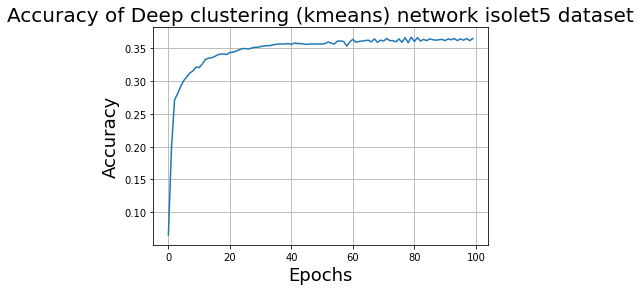

In [50]:
%pylab inline
plot(accur_list)
xlabel('Epochs',fontsize=18)
ylabel('Accuracy',fontsize=18)
title('Accuracy of Deep clustering (kmeans) network isolet5 dataset',fontsize=20)
grid()

In [52]:
isolet_notpretrained=accur_list

In [57]:
isolet_pretrain=accur_list

Populating the interactive namespace from numpy and matplotlib


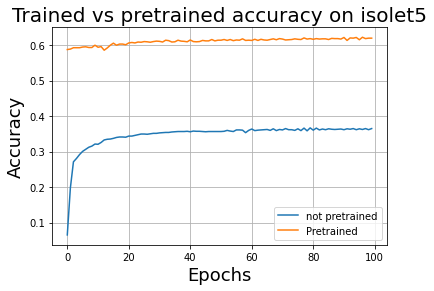

In [60]:
%pylab inline
plot(isolet_notpretrained,label='not pretrained')
plot(isolet_pretrain,label='Pretrained')
xlabel('Epochs',fontsize=18)
ylabel('Accuracy',fontsize=18)
title('Trained vs pretrained accuracy on isolet5',fontsize=20)
legend()
grid()

Populating the interactive namespace from numpy and matplotlib


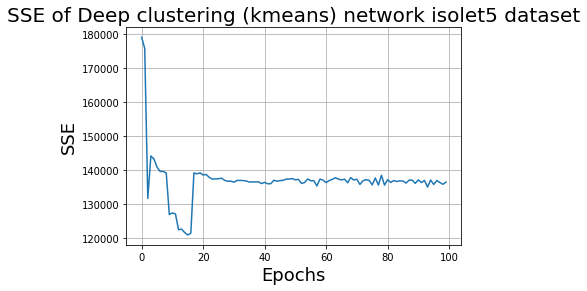

In [51]:
%pylab inline
plot(sse_list)
xlabel('Epochs',fontsize=18)
ylabel('SSE',fontsize=18)
title('SSE of Deep clustering (kmeans) network isolet5 dataset',fontsize=20)
grid()